In [1]:
using Revise; 
includet("TrajModules.jl")
using .atom_class
using .SystemSetup
using .utils
using .BeamClass
using .CoolTrap

In [2]:
using DifferentialEquations

In [10]:
using ProfileView
using BenchmarkTools
using PyPlot

In [3]:


function createSystem()
    BField(x, y, z) = 800E-4 * [0, 0, 1]
    atomType = cesiumAtom
    OurSystem = System(atomType, BField, -4e-6:0.4e-7:4e-6)
    return OurSystem
end
function createLight!(OurSystem)
    #clear_beams(OurSystem)
    stateF = (6, 1, 1.5, 5, 5)
    stateI = (6, 0, 0.5, 4, 4)
    detuning = 3e6
    I_mot = 14
    beamAngle = 45 * pi / 180


    println("Setting up MOT")
    updates0 = false
    LocAll::Vector{Float64} = [0, 0, 0]
    set_MOT(OurSystem, BeamProperties(LocAll, [-1.0, 0.0, 0.0], pol_v["sigma_m"]),  stateI, stateF, detuning, I_mot, updates0)
    set_MOT(OurSystem, BeamProperties(LocAll, [1.0, 0.0, 0.0], pol_v["sigma_p"]),  stateI, stateF, detuning, I_mot, updates0)
    #R1
    #set_MOT(OurSystem, BeamProperties(LocAll, [0, sin(beamAngle), cos(beamAngle)], pol_v["sigma_m"]),  stateI, stateF, detuning, I_mot,updates0)
    #set_MOT(OurSystem, BeamProperties(LocAll, [0, -sin(beamAngle), -cos(beamAngle)], pol_v["sigma_p"]),  stateI, stateF, detuning, I_mot, updates0)
    #R2
    #set_MOT(OurSystem, BeamProperties(LocAll, [0, -sin(beamAngle), cos(beamAngle)], pol_v["sigma_m"]),  stateI, stateF, detuning, I_mot, updates0)
    #set_MOT(OurSystem, BeamProperties(LocAll, [0, sin(beamAngle), -cos(beamAngle)], pol_v["sigma_p"]),  stateI, stateF, detuning, I_mot, updates0)

    println("Setting up Tweezer")

    #Tweezer
    stateI_T = (6, 1, 1 / 2)
    stateF_T = (6, 0, 1 / 2)
    wavelength_tweezer = 1064E-9
    trapR, trapZ = 2 * pi * 0.150e6, 2 * pi * 0.029e6

    set_tweezer(OurSystem, BeamProperties(LocAll, [0.0, 0.0, 1.0], pol_v["pi"]), stateI_T, stateF_T, wavelength_tweezer, trapR, trapZ)
    #join_Beams(OurSystem)
end

OurSystem = createSystem()
createLight!(OurSystem);


Setting up MOT


Fixing


Fixing
Setting up Tweezer


In [39]:
using Revise; 
includet("TrajModules.jl")
using .atom_class
using .SystemSetup
using .utils
using .BeamClass
using .CoolTrap

In [60]:
function simulate(u0, param, RHS)

    boundMin, boundMax = minimum(OurSystem.Environment.grid[1]), maximum(OurSystem.Environment.grid[1])
    conditionStop(y, t, integrator) = !any(boundMin + 1e-6 .< y[1:3]) || !any(y[1:3] .< boundMax - 1e-6)
    affect!(integrator) = terminate!(integrator)
    cb = DiscreteCallback(conditionStop, affect!)

    tspan = (0, 1e-3)
    prob = ODEProblem(RHS, u0, tspan, param)
    dt = 2e-9
    sol = solve(prob, RK4(), dt=dt, adaptive=false)#, callback=cb, abstol=1e-3, reltol=1e-3)
    return sol.t, hcat(sol.u...)
end


simulate (generic function with 1 method)

In [64]:
u0, param, RHS = InitializeProblem(OurSystem, 1, 1e-6, "Fabs_spont_R", opt_args=0.0);
t, u = simulate(u0, param, RHS)
x, y, z, vx, vy, vz = u[1, :],  u[2, :],  u[3, :],  u[4, :], u[5, :], u[6, :];

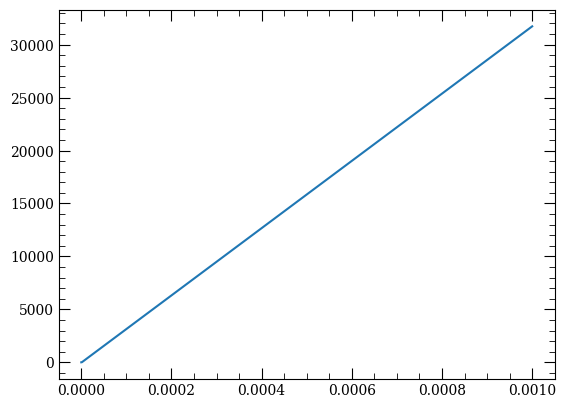

In [68]:

fig = plt.figure()
plot(t, vx)
#xlim([0, 1e-3])
fig


In [373]:
using Random
a = [1, 2, 3, 4, 5]
b = randn(length(a))
println(findfirst(a .> b))

1


In [68]:
push!(tupl3, 2)

MethodError: MethodError: no method matching push!(::Tuple{Int64, Int64, Int64, String}, ::Int64)
Closest candidates are:
  push!(::Any, ::Any, !Matched::Any) at abstractarray.jl:3059
  push!(::Any, ::Any, !Matched::Any, !Matched::Any...) at abstractarray.jl:3060
  push!(!Matched::DataStructures.DisjointSets{T}, ::T) where T at ~/.julia/packages/DataStructures/CvTHU/src/disjoint_set.jl:230
  ...

In [339]:
a = [1, 2, 3, 2]
b = rand(length(a))
inds = findall(a .> b)
argmax(a[inds])

3